In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
from glob import glob
from scipy import optimize
from hampel import hampel

%matplotlib notebook

In [2]:
files = glob('**/*.dat', recursive=True)
path = '/Users/wendy/Desktop/111/GMA/Wendy&Yilun/wendy have fun/01_28_2022_17_09_05/final_aved_Data3min.csv'


In [3]:
file_Mn = [f for f in files if ("Mn" in f and 'Mn_' not in f)]
file_other = [f for f in files if "Mn" not in f]

In [4]:
def cutdat(data,lowlim,highlim):
    data_x = data['freq'].values
    data_y = data['vals'].values
    data_y = data_y[(data_x > low_lim) & (data_x < up_lim)]
    data_x = data_x[(data_x > low_lim) & (data_x < up_lim)]
    return(data_x,data_y)

In [5]:
background = pd.read_csv(path)
def subtract(data,time,background = background,filenumber = 1):
    freq = data[0].values
    data_sub = data[1].values-background['values'].values/3*(time/60)
    err = (np.sqrt(data[1].values) + (time/180)**2*background['std'])/filenumber
    result = pd.DataFrame([])
    result['freq'] = freq
    result['vals'] = data_sub
    result['std'] = err
    
    return result

In [6]:
def exp(x,ave,sigma,amp,c,b):
    return(amp*np.exp(-(x-ave)**2/(2*sigma**2))+c*x+b)
def mt_fit(data_x,data_y,err_x ,err_y,up_lim,low_lim,N,p0=[1.25,0.05,25,0.1, 0]):

    

    data_y = data_y[(data_x > low_lim) & (data_x < up_lim)]
    
    if type(err_x) is not int:
        err_x = err_x[(data_x > low_lim) & (data_x < up_lim)]
    if type(err_y) is not int:
        err_y = err_y[(data_x > low_lim) & (data_x < up_lim)]
    data_x = data_x[(data_x > low_lim) & (data_x < up_lim)]
    
    func = exp
    ave = []
    sigma = []
    amp = []
    c = []
    b = []
    for i in range(N):
#         data_xe = np.array(data_x)+np.random.normal(0,err_x)
#         data_ye = np.array(data_y)+np.random.normal(0,err_y)

        data_xe = np.random.normal(data_x,err_x)
        data_ye = np.random.normal(data_y,err_y)

        paras, _ = optimize.curve_fit(func, data_xe, data_ye,p0 = p0)
        ave += [paras[0]]
#         print(ave)
        sigma += [paras[1]]
        amp += [paras[2]]
        c += [paras[3]]
        b += [paras[4]]
        
    
#     fig, ax = plt.subplots(figsize = (16,12))

#     ax.scatter(data_x, data_y,s = 0.3)
#     ax.plot(data_x,exp(data_x,*paras), )
#     plt.plot()
    ave_a = np.mean(ave)
    sigma_a = np.mean(sigma)
    amp_a = np.mean(amp)
    c_a = np.mean(c)
    b_a = np.mean(b)
    paras = [ave_a,sigma_a,amp_a,c_a,b_a]
    
    ave_err = np.std(ave)
    sigma_err = np.std(sigma)
    amp_err = np.std(amp)
    c_err = np.std(c)
    b_err = np.std(b)
    errs = [ave_err,sigma_err,amp_err,c_err,b_err]
    
    return (paras, errs)

## Mn 10min spectrum

In [7]:
#first read data and sum/average it 
data = pd.read_csv(file_Mn[0],skiprows = 2,sep="\s+", header = None,usecols = [0,1])
vals = np.empty(len(data[1]))
vals.fill(0)
for f in file_Mn:
    data = pd.read_csv(f,skiprows = 2,sep="\s+", header = None,usecols = [0,1])
    vals += np.array(data[1].values,dtype = int)/len(file_Mn)
data[1] = vals

In [8]:
#then manipulate data to subtract from the background
dat_sub_Mn = subtract(data,600,filenumber = len(file_Mn))

In [9]:
#plot data and find the optimal range
up_lim = 1.4
low_lim = 1.1
#Finally do the montecarlo fit with estimate of error
dat_sub = dat_sub_Mn
Mn11_paras, Mn11_errs = mt_fit(dat_sub['freq'].values,dat_sub['vals'].values,0, dat_sub['std'].values, \
       up_lim,low_lim,1000)

/Users/wendy/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/wendy/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/wendy/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


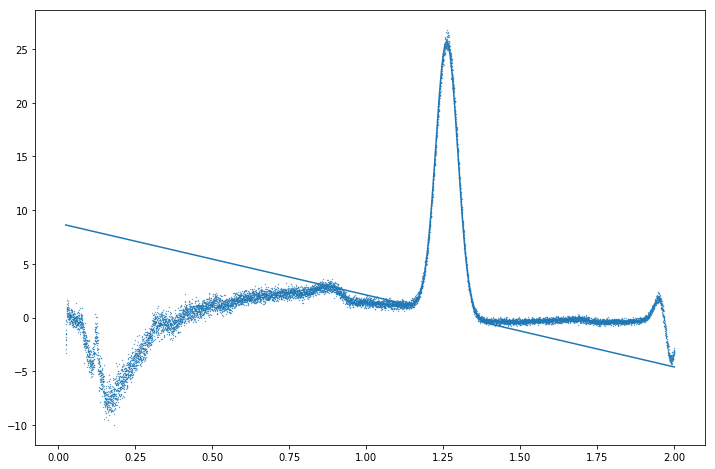

In [10]:
fig,ax = plt.subplots(figsize = (12,8))
ax.scatter(dat_sub_Mn['freq'],dat_sub_Mn['vals'],s = 0.1)
ax.plot(dat_sub_Mn['freq'],exp(dat_sub_Mn['freq'],*Mn11_paras))

## Cs 300s spectrum

In [11]:
#first read data and sum/average it 
print(file_other[0])
data = pd.read_csv(file_other[0],skiprows = 2,sep="\s+", header = None,usecols = [0,1])

01_27_2022_16_42_22/Cs_301s.dat


In [12]:
#then manipulate data to subtract from the background
dat_sub_cs300 = subtract(data,300,filenumber = 1)

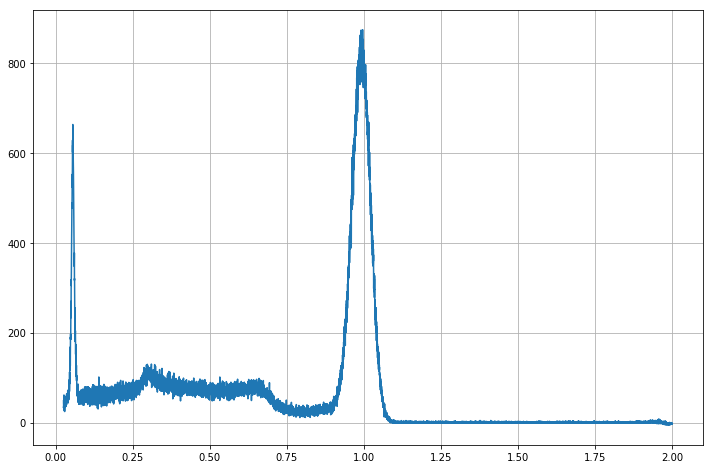

In [13]:
fig, ax = plt.subplots(figsize = (12,8))

ax.plot(dat_sub_cs300['freq'],dat_sub_cs300['vals'])
ax.grid()

In [14]:
#plot data and find the optimal range
up_lim = 1.2
low_lim = 0.8
#Finally do the montecarlo fit with estimate of error
dat_sub = dat_sub_cs300
datx, daty = cutdat(dat_sub,low_lim,up_lim)
par, _ = optimize.curve_fit(exp,dat_sub['freq'].values,dat_sub['vals'].values)
Cs11_paras, Cs11_errs = mt_fit(dat_sub['freq'].values,dat_sub['vals'].values,0, dat_sub['std'].values, \
       up_lim,low_lim,1000,p0 = par)

In [15]:
Cs11_paras

[0.9909472108168587,
 -0.029942774679761426,
 803.6181455726972,
 -98.0577907630229,
 111.09425317743374]

(0.8, 1.2)

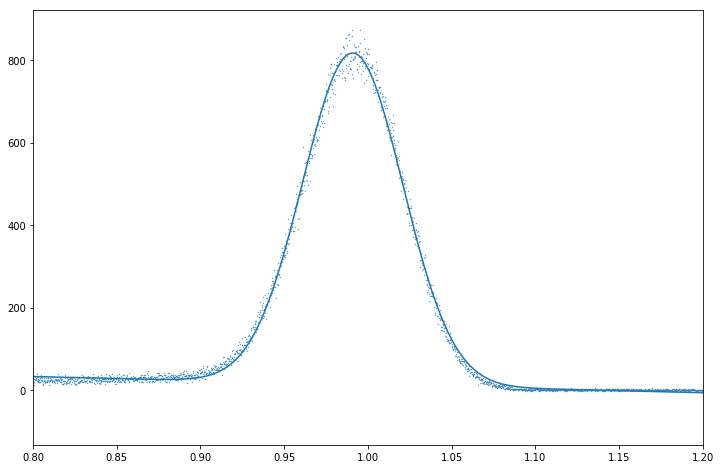

In [16]:
fig,ax = plt.subplots(figsize = (12,8))
ax.scatter(dat_sub_cs300['freq'],dat_sub_cs300['vals'],s = 0.1)
ax.plot(dat_sub_cs300['freq'],exp(dat_sub_cs300['freq'],*Cs11_paras))
ax.set_xlim(low_lim,up_lim)

## Na 270s spectrum

In [17]:
#first read data and sum/average it 
print(file_other[1])
data = pd.read_csv(file_other[1],skiprows = 2,sep="\s+", header = None,usecols = [0,1])

01_27_2022_16_24_56/Na_270s.dat


In [18]:
#then manipulate data to subtract from the background
dat_sub_Na270 = subtract(data,270,filenumber = 1)

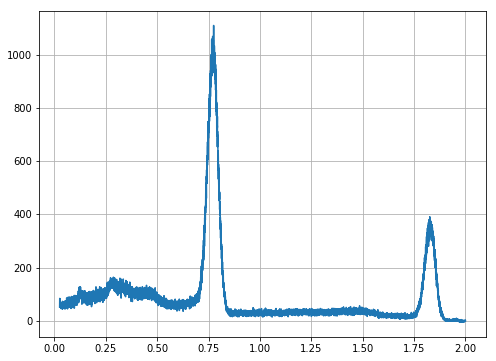

In [19]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(dat_sub_Na270['freq'],dat_sub_Na270['vals'])
ax.grid()

In [20]:
#Peak 1
#plot data and find the optimal range
up_lim = 0.9
low_lim = 0.65
p0 = [0.79,0.01,1000,0,0]
#Finally do the montecarlo fit with estimate of error
dat_sub = dat_sub_Na270
datx, daty = cutdat(dat_sub,low_lim,up_lim)
par, _ = optimize.curve_fit(exp,datx,daty,p0 = p0)
Na11_paras, Na11_errs = mt_fit(dat_sub['freq'].values,dat_sub['vals'].values,0, dat_sub['std'].values, \
       up_lim,low_lim,1000,p0 = par)

(0.65, 0.9)

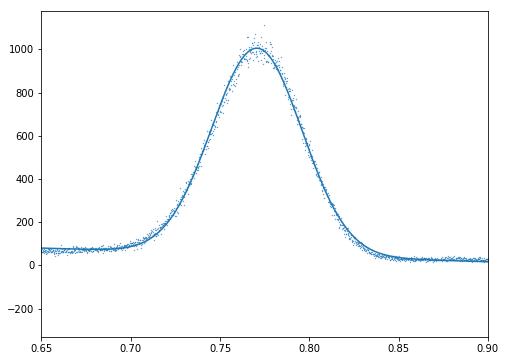

In [21]:
datass = dat_sub_Na270
parass = Na11_paras

fig,ax = plt.subplots(figsize = (8,6))
ax.scatter(datass['freq'],datass['vals'],s = 0.1)
ax.plot(datass['freq'],exp(datass['freq'],*parass))
ax.set_xlim(low_lim,up_lim)

In [22]:
#Peak 2
#plot data and find the optimal range
up_lim = 1.95
low_lim = 1.7
p0 = [1.82,0.01,400,0,0]

#Finally do the montecarlo fit with estimate of error
dat_sub = dat_sub_Na270
par, _ = optimize.curve_fit(exp,dat_sub['freq'].values,dat_sub['vals'].values,p0=p0)
Na12_paras, Na12_errs = mt_fit(dat_sub['freq'].values,dat_sub['vals'].values,0, dat_sub['std'].values, \
       up_lim,low_lim,1000,p0 = par)

(1.7, 1.95)

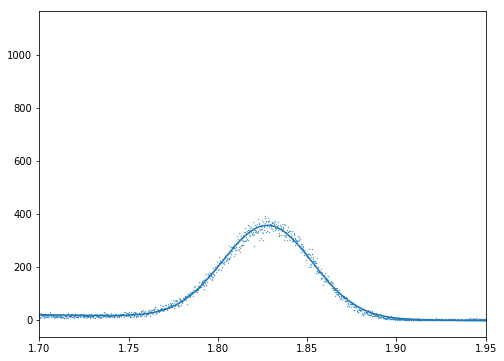

In [23]:
datass = dat_sub_Na270
parass = Na12_paras

fig,ax = plt.subplots(figsize = (8,6))
ax.scatter(datass['freq'],datass['vals'],s = 0.1)
ax.plot(datass['freq'],exp(datass['freq'],*parass))
ax.set_xlim(low_lim,up_lim)

## Co 286s spectrum

In [24]:
#first read data and sum/average it 
print(file_other[2])
data = pd.read_csv(file_other[2],skiprows = 2,sep="\s+", header = None,usecols = [0,1])

01_27_2022_16_49_34/Co_286s.dat


In [25]:
#then manipulate data to subtract from the background
dat_sub_Co286 = subtract(data,286,filenumber = 1)

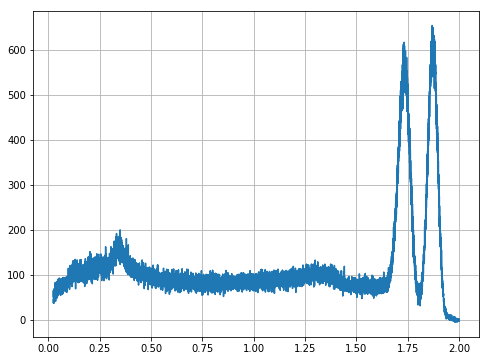

In [26]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(dat_sub_Co286['freq'],dat_sub_Co286['vals'])
ax.grid()

In [27]:
#Peak 1
#plot data and find the optimal range
up_lim = 1.81
low_lim = 1.6
p0 = [1.725,0.01,500,0,0]
#Finally do the montecarlo fit with estimate of error
dat_sub = dat_sub_Co286
datx, daty = cutdat(dat_sub,low_lim,up_lim)
par, _ = optimize.curve_fit(exp,datx,daty,p0 = p0)
Co11_paras, Co11_errs = mt_fit(dat_sub['freq'].values,dat_sub['vals'].values,0, dat_sub['std'].values, \
       up_lim,low_lim,1000,p0 = par)

(1.6, 1.81)

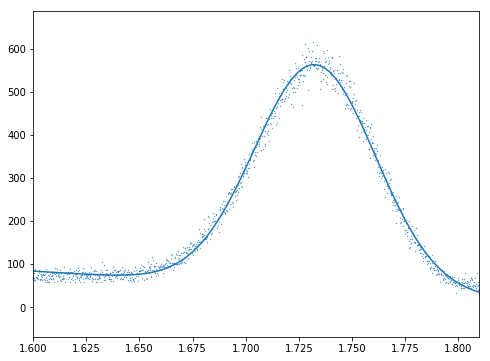

In [28]:
datass = dat_sub_Co286
parass = Co11_paras

fig,ax = plt.subplots(figsize = (8,6))
ax.scatter(datass['freq'],datass['vals'],s = 0.1)
ax.plot(datass['freq'],exp(datass['freq'],*parass))
ax.set_xlim(low_lim,up_lim)

In [29]:
#Peak 2
#plot data and find the optimal range
up_lim = 2
low_lim = 1.81
p0 = [1.87,0.01,600,0,0]

#Finally do the montecarlo fit with estimate of error
dat_sub = dat_sub_Co286
par, _ = optimize.curve_fit(exp,dat_sub['freq'].values,dat_sub['vals'].values,p0=p0)
Co12_paras, Co12_errs = mt_fit(dat_sub['freq'].values,dat_sub['vals'].values,0, dat_sub['std'].values, \
       up_lim,low_lim,1000,p0 = par)

(1.81, 2)

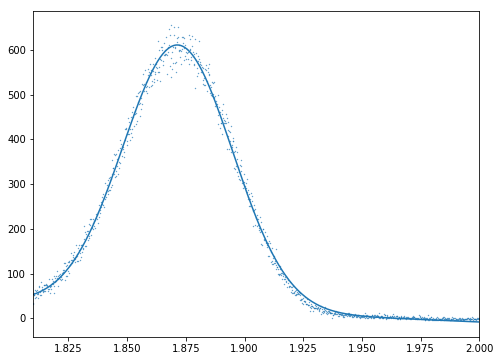

In [30]:
datass = dat_sub_Co286
parass = Co12_paras

fig,ax = plt.subplots(figsize = (8,6))
ax.scatter(datass['freq'],datass['vals'],s = 0.1)
ax.plot(datass['freq'],exp(datass['freq'],*parass))
ax.set_xlim(low_lim,up_lim)

## Na 309s spectrum

In [31]:
#first read data and sum/average it 
print(file_other[3])
data = pd.read_csv(file_other[3],skiprows = 2,sep="\s+", header = None,usecols = [0,1])

01_27_2022_16_30_09/Na_309s.dat


In [32]:
#then manipulate data to subtract from the background
dat_sub_Na309 = subtract(data,309,filenumber = 1)

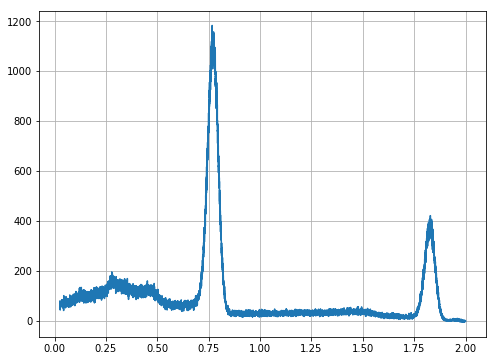

In [33]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(dat_sub_Na309['freq'],dat_sub_Na309['vals'])
ax.grid()

In [34]:
#Peak 1
#plot data and find the optimal range
up_lim = 0.9
low_lim = 0.6
p0 = [0.77,0.01,1000,0,0]
#Finally do the montecarlo fit with estimate of error
dat_sub = dat_sub_Na309
datx, daty = cutdat(dat_sub,low_lim,up_lim)
par, _ = optimize.curve_fit(exp,datx,daty,p0 = p0)
Na21_paras, Na21_errs = mt_fit(dat_sub['freq'].values,dat_sub['vals'].values,0, dat_sub['std'].values, \
       up_lim,low_lim,1000,p0 = par)

(0.6, 0.9)

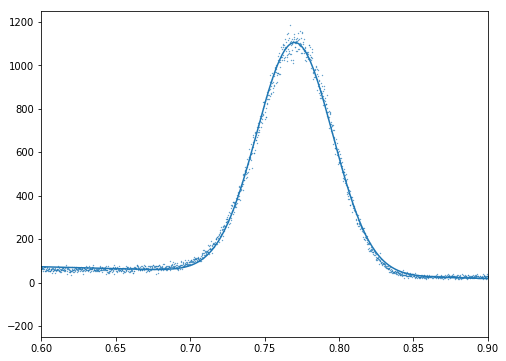

In [35]:
datass = dat_sub_Na309
parass = Na21_paras

fig,ax = plt.subplots(figsize = (8,6))
ax.scatter(datass['freq'],datass['vals'],s = 0.1)
ax.plot(datass['freq'],exp(datass['freq'],*parass))
ax.set_xlim(low_lim,up_lim)

In [36]:
#Peak 2
#plot data and find the optimal range
up_lim = 1.9
low_lim = 1.725
p0 = [1.825,0.01,500,0,0]
#Finally do the montecarlo fit with estimate of error
dat_sub = dat_sub_Na309
datx, daty = cutdat(dat_sub,low_lim,up_lim)
par, _ = optimize.curve_fit(exp,datx,daty,p0 = p0)
Na22_paras, Na22_errs = mt_fit(dat_sub['freq'].values,dat_sub['vals'].values,0, dat_sub['std'].values, \
       up_lim,low_lim,1000,p0 = par)

(1.725, 1.9)

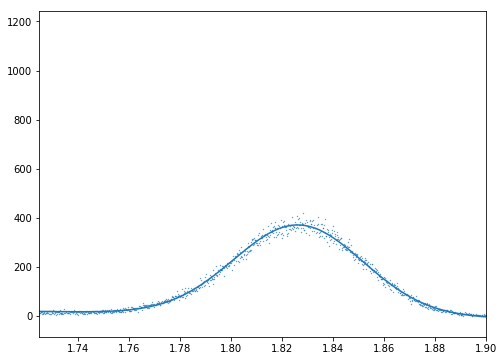

In [37]:
datass = dat_sub_Na309
parass = Na22_paras

fig,ax = plt.subplots(figsize = (8,6))
ax.scatter(datass['freq'],datass['vals'],s = 0.1)
ax.plot(datass['freq'],exp(datass['freq'],*parass))
ax.set_xlim(low_lim,up_lim)

In [38]:
#Extract peak location from the given fits
#Average (peak x location)

result = []
err = []

result += [[0.511,Na11_paras[0]]]
err += [[0.511,Na11_errs[0]]]
result += [[0.511,Na21_paras[0]]]
err += [[0.511,Na21_errs[0]]]

result += [[1.28,Na12_paras[0]]]
err += [[1.28,Na12_errs[0]]]
result += [[1.28,Na22_paras[0]]]
err += [[1.28,Na22_errs[0]]]

result += [[0.6616,Cs11_paras[0]]]
err += [[0.6616,Cs11_errs[0]]]

result += [[1.17,Co11_paras[0]]]
err += [[1.17,Co11_errs[0]]]

result += [[1.33,Co12_paras[0]]]
err += [[1.33,Co12_errs[0]]]

result += [[0.84,Mn11_paras[0]]]
err += [[0.84,Mn11_errs[0]]]


In [45]:
err

[[0.511, 6.273554779133583e-05],
 [0.511, 5.526257844656903e-05],
 [1.28, 9.77353542158701e-05],
 [1.28, 9.998459988007644e-05],
 [0.6616, 6.882735304953832e-05],
 [1.17, 0.00010007453247652711],
 [1.33, 8.671810676313679e-05],
 [0.84, 4.023079410101578e-06]]

In [46]:
result

[[0.511, 0.7706702852609133],
 [0.511, 0.770274856528129],
 [1.28, 1.8277721441151222],
 [1.28, 1.8264610207322187],
 [0.6616, 0.9909472108168587],
 [1.17, 1.732625471242736],
 [1.33, 1.8715697487399405],
 [0.84, 1.2614904643070486]]

In [44]:
Na11_errs

[6.273554779133583e-05,
 5.970204768074278e-05,
 2.3204417116310534,
 3.4258600995360378,
 2.837610943864662]

<ErrorbarContainer object of 3 artists>

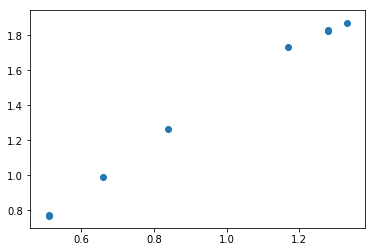

In [41]:
fig,ax = plt.subplots()

plt.scatter(np.array(result)[:, 0],np.array(result)[:, 1],)
ax.errorbar(np.array(result)[:, 0],np.array(result)[:, 1],np.array(err)[:, 1],ls = 'none')

In [43]:
np.array(err)

array([[5.11000000e-01, 6.27355478e-05],
       [5.11000000e-01, 5.52625784e-05],
       [1.28000000e+00, 9.77353542e-05],
       [1.28000000e+00, 9.99845999e-05],
       [6.61600000e-01, 6.88273530e-05],
       [1.17000000e+00, 1.00074532e-04],
       [1.33000000e+00, 8.67181068e-05],
       [8.40000000e-01, 4.02307941e-06]])

In [48]:
def linear(x,a,b,):
    return(a*x+b)
xdata = np.array(result)[:, 0]
ydata = np.array(result)[:, 1]
yerr = np.array(err)[:, 1]
# optimize.curve_fit(linear, xdata, ydata)

In [47]:
def mt_fit_simple(func,data_x,data_y,err_x ,err_y,N):
    
    parass = []
    errss = []
    for i in range(N):
#         data_xe = np.array(data_x)+np.random.normal(0,err_x)
#         data_ye = np.array(data_y)+np.random.normal(0,err_y)

        data_xe = np.random.normal(data_x,err_x)
        data_ye = np.random.normal(data_y,err_y)
#         print(data_ye)

        paras, errs = optimize.curve_fit(func, data_xe, data_ye,)
        parass += [paras]
        errss += [errs]
        
    return (np.array(parass), np.array(errss))

In [50]:
parass, errss = mt_fit_simple(linear,xdata,ydata,0.0,yerr,1000)

In [57]:
slope = np.mean(parass[:,0])
slope_err = np.std(parass[:,0])

intercept = np.mean(parass[:,1])
intercept_err = np.std(parass[:,1])

In [58]:
slope

1.3686994500064555

In [59]:
intercept

0.0840178701718588